In [ ]:
#  Read the CSV file
import pandas as pd

# Read the credit card default dataset
credit_card_df = pd.read_csv("default_of_credit_card_clients.csv")

# Preview the dataset
credit_card_df.head()



,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
# Rename target column for consistency
credit_card_df.rename(columns={"default.payment.next.month": "default"}, inplace=True)


In [ ]:
# Check for missing values
credit_card_df.isnull().sum()


,0
ID,0
LIMIT_BAL,0
SEX,0
EDUCATION,0
MARRIAGE,0
AGE,0
PAY_0,0
PAY_2,0
PAY_3,0
PAY_4,0


In [ ]:
# Create a new feature: average pay delay from PAY_0 to PAY_6
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
credit_card_df['AVG_PAY_DELAY'] = credit_card_df[pay_cols].mean(axis=1)


In [ ]:
# One-hot encode EDUCATION and MARRIAGE
credit_card_df_encoded = pd.get_dummies(
    credit_card_df,
    columns=['EDUCATION', 'MARRIAGE'],
    drop_first=True  # to avoid multicollinearity
)

# Confirm new shape and column names
credit_card_df_encoded.shape, credit_card_df_encoded.columns

((30000, 33),
 Index(['ID', 'LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
        'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
        'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
        'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month',
        'AVG_PAY_DELAY', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3',
        'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6', 'MARRIAGE_1', 'MARRIAGE_2',
        'MARRIAGE_3'],
       dtype='object'))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

possible_targets = ['default', 'default payment next month', 'default.payment.next.month']
target_col = next((c for c in possible_targets if c in credit_card_df.columns), None)
assert target_col is not None, "Target column not found. Check your dataframe columns."

# 1) Quick stats
print("Shape:", credit_card_df.shape)
print("\nSummary Stats:\n", credit_card_df.describe())
print("\nMissing Values:\n", credit_card_df.isnull().sum())

# 2) Target distribution
sns.countplot(x=target_col, data=credit_card_df)
plt.title("Credit Card Default Distribution")
plt.xlabel(f"{target_col} (0 = No, 1 = Yes)")
plt.show()

# 3) A few histograms
credit_card_df[['LIMIT_BAL', 'AGE', 'BILL_AMT1']].hist(bins=20, figsize=(10, 4), edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()

# 4) Correlation heatmap (numeric-only)
numeric_df = credit_card_df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Drop ID column
credit_card_df_encoded = credit_card_df_encoded.drop(columns=['ID'])

# Separate features and target
X = credit_card_df_encoded.drop(columns=['default payment next month'])
y = credit_card_df_encoded['default payment next month']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#  Train baseline logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

#  Predict and evaluate
y_pred = logreg.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[4532  141]
 [1048  279]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88      4673
           1       0.66      0.21      0.32      1327

    accuracy                           0.80      6000
   macro avg       0.74      0.59      0.60      6000
weighted avg       0.78      0.80      0.76      6000



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
 [[4529  144]
 [1003  324]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.76      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000

ROC AUC Score: 0.71


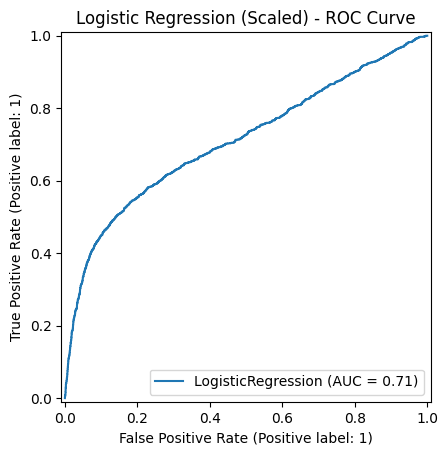

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Retrain logistic regression
logreg_scaled = LogisticRegression(max_iter=2000)
logreg_scaled.fit(X_train_scaled, y_train)

# Predict class labels and probabilities
y_pred_scaled = logreg_scaled.predict(X_test_scaled)
y_probs = logreg_scaled.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_scaled))
print("\nClassification Report:\n", classification_report(y_test, y_pred_scaled))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_probs), 3))

# Plot ROC Curve
RocCurveDisplay.from_estimator(logreg_scaled, X_test_scaled, y_test)
plt.title("Logistic Regression (Scaled) - ROC Curve")
plt.show()


Confusion Matrix:
 [[4424  249]
 [ 873  454]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.65      0.34      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.64      0.67      6000
weighted avg       0.79      0.81      0.79      6000

Random Forest ROC AUC Score: 0.759


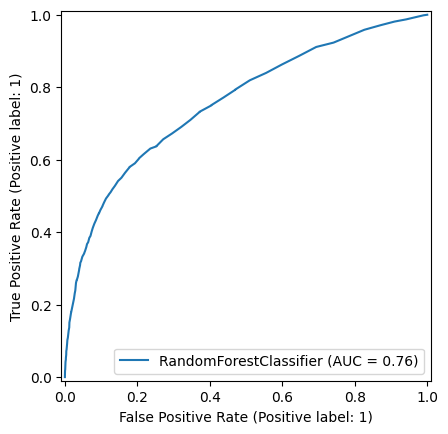

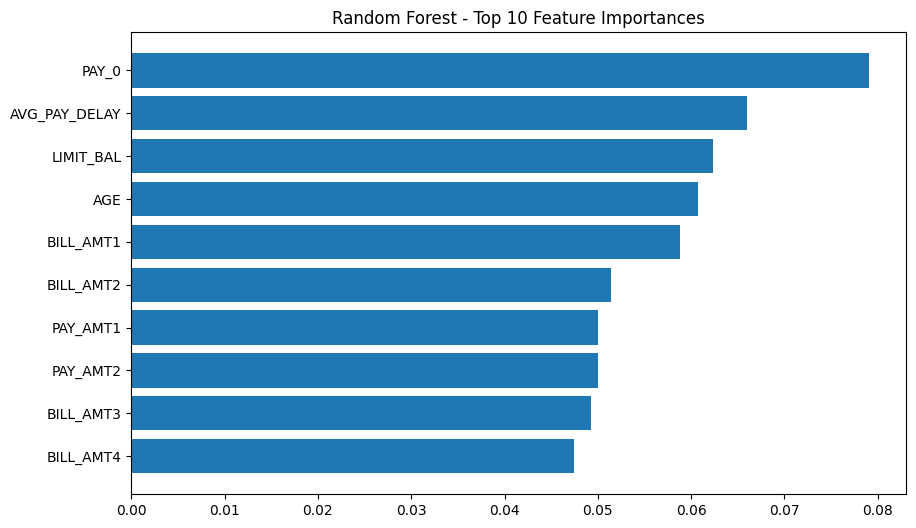

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest with balanced class weights
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

#  ROC AUC
auc_rf = roc_auc_score(y_test, y_probs_rf)
print("Random Forest ROC AUC Score:", round(auc_rf, 3))

# Plot ROC
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)

import matplotlib.pyplot as plt
import numpy as np

# Random Forest Feature Importances
importances_rf = rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
features_rf = X_train.columns[indices_rf]

plt.figure(figsize=(10,6))
plt.title("Random Forest - Top 10 Feature Importances")
plt.barh(features_rf[:10], importances_rf[indices_rf[:10]])
plt.gca().invert_yaxis()
plt.show()


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF Parameters: {'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 150}

 Tuned RF Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4673
           1       0.51      0.57      0.54      1327

    accuracy                           0.78      6000
   macro avg       0.69      0.71      0.70      6000
weighted avg       0.79      0.78      0.79      6000

Tuned RF ROC AUC Score: 0.773


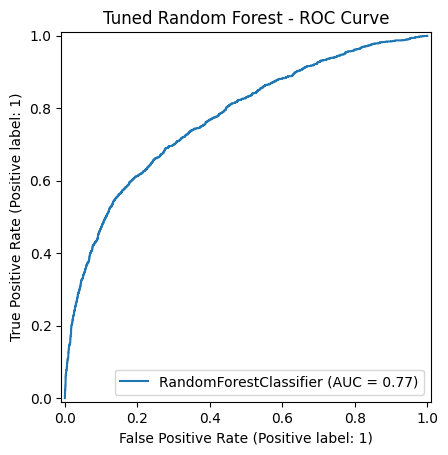

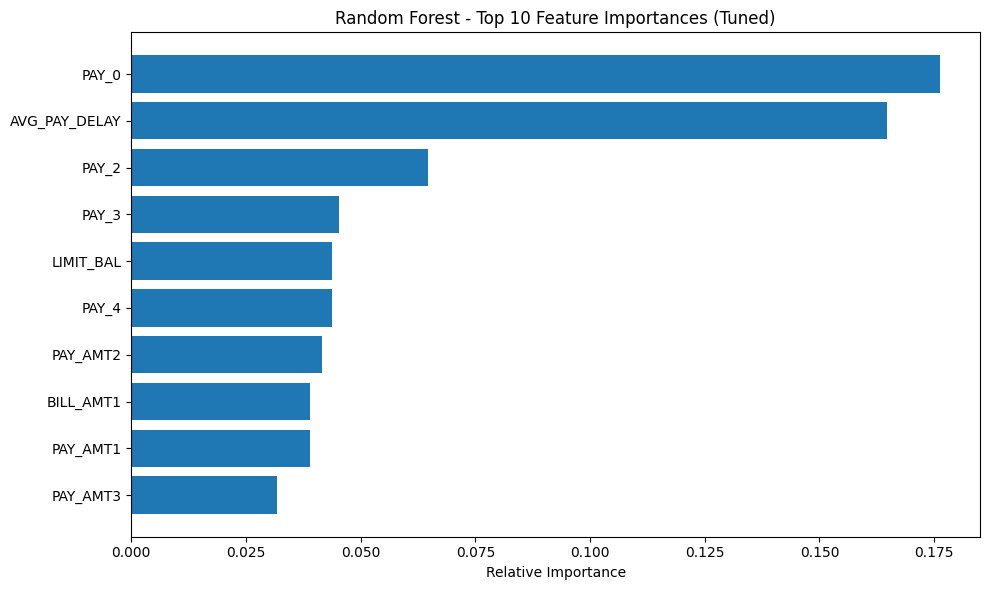

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

# Define hyperparameter grid for Random Forest
rf_params = {
    'n_estimators': [100, 150],         # Number of trees
    'max_depth': [None, 10, 20],        # Maximum depth
    'min_samples_split': [2, 4]         # Minimum number of samples to split
}

# Grid search with cross-validation
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=rf_params,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)

# Extract best model
best_rf_model = rf_grid.best_estimator_
print("RF Parameters:", rf_grid.best_params_)

# Predict and evaluate
y_pred_rf = best_rf_model.predict(X_test)
y_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]

print("\n Tuned RF Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Tuned RF ROC AUC Score:", round(roc_auc_score(y_test, y_prob_rf), 3))

# ROC Curve
RocCurveDisplay.from_estimator(best_rf_model, X_test, y_test)
plt.title("Tuned Random Forest - ROC Curve")
plt.show()

# Feature Importances - Top 10
importances_rf = best_rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)[-10:]
features_rf = [X.columns[i] for i in indices_rf]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], align='center')
plt.yticks(range(len(indices_rf)), features_rf)
plt.title("Random Forest - Top 10 Feature Importances (Tuned)")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:03:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[3777  896]
 [ 568  759]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      4673
           1       0.46      0.57      0.51      1327

    accuracy                           0.76      6000
   macro avg       0.66      0.69      0.67      6000
weighted avg       0.78      0.76      0.76      6000

XGBoost ROC AUC Score: 0.76


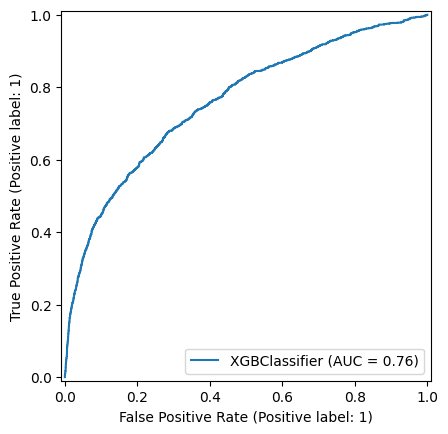

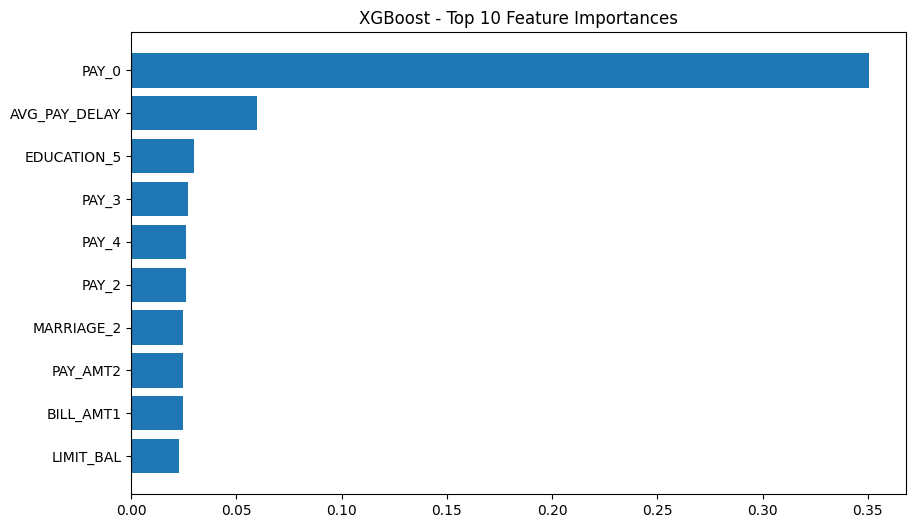

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

# Compute scale_pos_weight to address imbalance
scale_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Train XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_ratio,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
y_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost ROC AUC Score:", round(roc_auc_score(y_test, y_probs_xgb), 3))

#  Plot ROC
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test)


# XGBoost Feature Importances
importances_xgb = xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
features_xgb = X_train.columns[indices_xgb]

plt.figure(figsize=(10,6))
plt.title("XGBoost - Top 10 Feature Importances")
plt.barh(features_xgb[:10], importances_xgb[indices_xgb[:10]])
plt.gca().invert_yaxis()
plt.show()


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:04:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

 Tuned XGB Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4673
           1       0.47      0.62      0.53      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.71      0.68      6000
weighted avg       0.79      0.76      0.77      6000

 Tuned XGB ROC AUC Score: 0.778


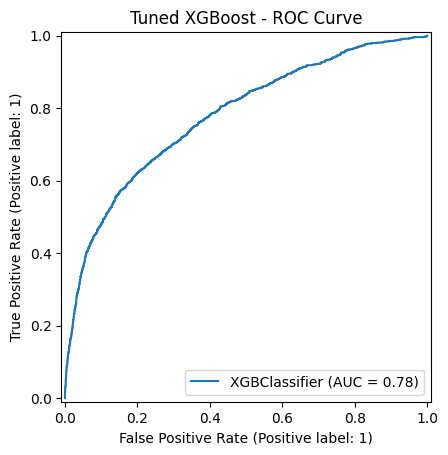

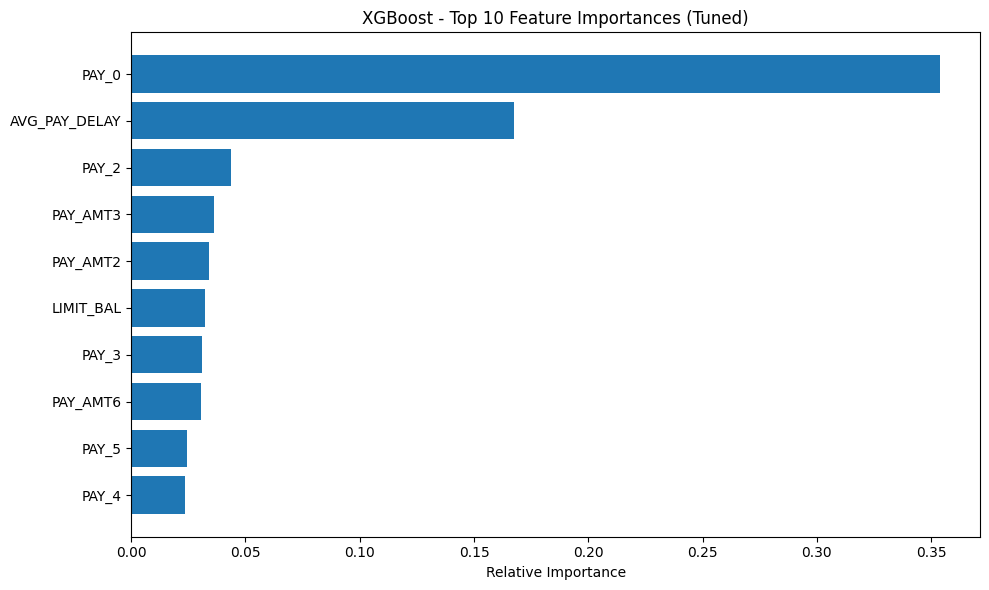

In [ ]:
from xgboost import XGBClassifier

# Define hyperparameter grid for XGBoost
xgb_params = {
    'n_estimators': [100, 150],         # Number of boosting rounds
    'max_depth': [3, 5],                # Maximum depth
    'learning_rate': [0.1, 0.05]        # Learning rate (shrinkage)
}

# Compute imbalance ratio
scale_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Grid search with cross-validation
xgb_grid = GridSearchCV(
    estimator=XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_ratio,
        random_state=42
    ),
    param_grid=xgb_params,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)

# Extract best model
best_xgb_model = xgb_grid.best_estimator_
print("XGB Parameters:", xgb_grid.best_params_)

# Predict and evaluate
y_pred_xgb = best_xgb_model.predict(X_test)
y_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

print("\n Tuned XGB Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(" Tuned XGB ROC AUC Score:", round(roc_auc_score(y_test, y_prob_xgb), 3))

# ROC Curve
RocCurveDisplay.from_estimator(best_xgb_model, X_test, y_test)
plt.title("Tuned XGBoost - ROC Curve")
plt.show()

# Feature Importances - Top 10
importances_xgb = best_xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)[-10:]
features_xgb = [X.columns[i] for i in indices_xgb]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], align='center')
plt.yticks(range(len(indices_xgb)), features_xgb)
plt.title("XGBoost - Top 10 Feature Importances (Tuned)")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

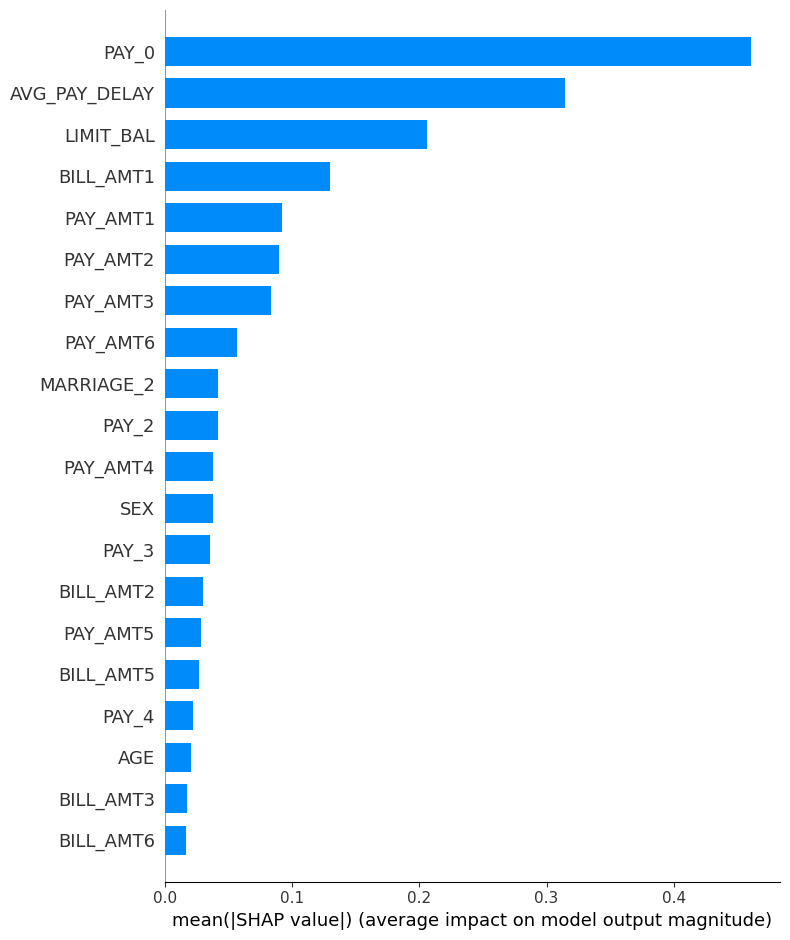

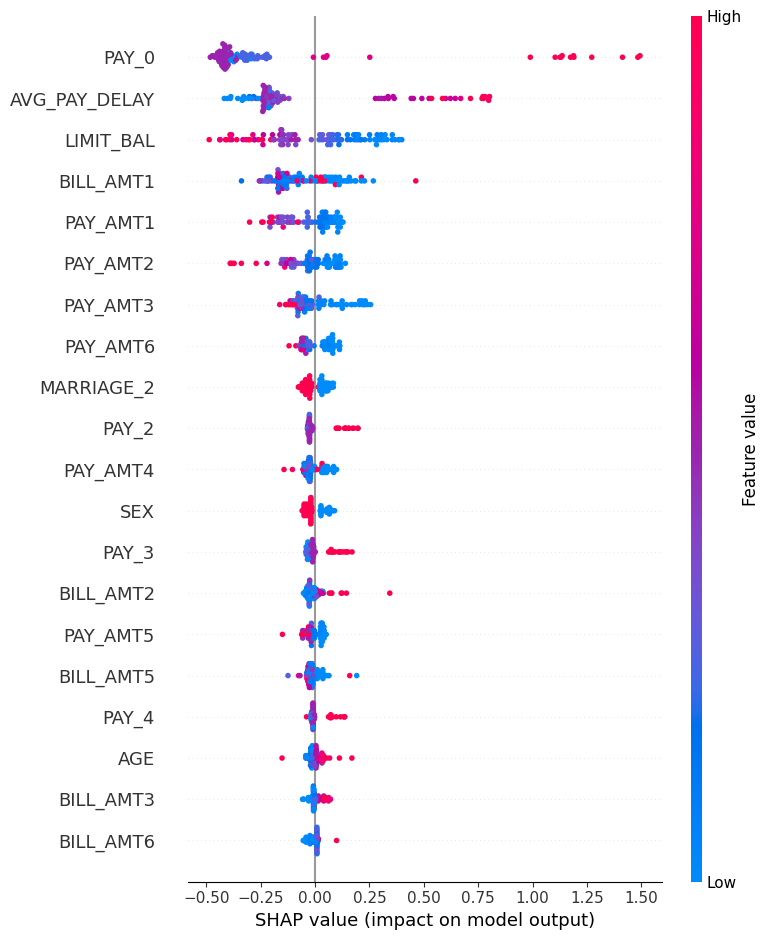

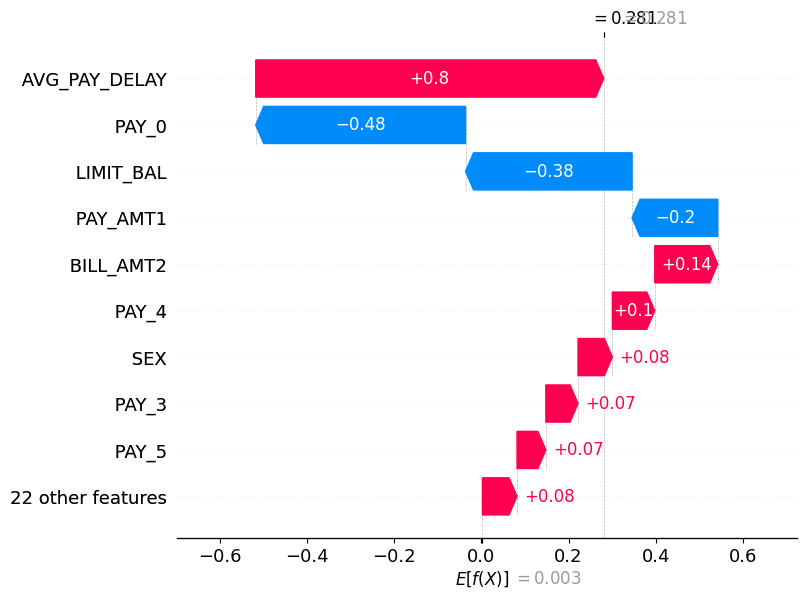

In [ ]:


#  Import SHAP and other libraries
import shap
import matplotlib.pyplot as plt

#  Use TreeExplainer for XGBoost
explainer_xgb = shap.TreeExplainer(best_xgb_model)

#  Take a sample to reduce computation (e.g., 100 rows from test set)
X_sample_xgb = X_test.sample(n=100, random_state=42)

#  Compute SHAP values
shap_values_xgb = explainer_xgb.shap_values(X_sample_xgb)

#  Global Feature Importance Plot (bar)
shap.summary_plot(shap_values_xgb, X_sample_xgb, plot_type="bar", show=True)

# Beeswarm Plot (more detailed global impact)
shap.summary_plot(shap_values_xgb, X_sample_xgb, show=True)

#  Local Explanation for a single prediction
sample_index = 0  # Change index for different predictions
shap.plots._waterfall.waterfall_legacy(
    explainer_xgb.expected_value,
    shap_values_xgb[sample_index],
    X_sample_xgb.iloc[sample_index]
)
